In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.utils import to_categorical
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from time import time
import logging#程序进展信息
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split#分割数据集
#from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people#下载数据集
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

Using TensorFlow backend.


In [2]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)
#读入文件
fer_data = h5py.File('./data.h5', 'r', driver='core')
#提取出Training_pixel
fer_x = np.asarray(fer_data['Training_pixel']).reshape((28709, 48*48))
#提取出Training_label
fer_y = fer_data['Training_label']
#定义训练集
X_train = fer_x
#拆分公共训练集
X_test_public=np.asarray(fer_data['PublicTest_pixel']).reshape((3589,48*48))
#拆分Private训练集
X_test_private=np.asarray(fer_data['PrivateTest_pixel']).reshape((3589,48*48))
num_train = X_train.shape[0]
num_val_public=X_test_public.shape[0]
num_val_private=X_test_private.shape[0]

In [3]:
#打印训练集个数
print('Training: ',X_train.shape)

Training:  (28709, 2304)


In [4]:
#打印公共测试集个数
print('PublicTest:',X_test_public.shape)

PublicTest: (3589, 2304)


In [5]:
#打印Private测试集个数
print('PrivateTest:',X_test_private.shape)

PrivateTest: (3589, 2304)


In [6]:
#标签相关
Y_train = fer_data['Training_label']
Y_train = to_categorical(Y_train, num_classes)
Y_test_public=fer_data['PublicTest_label']
Y_test_private=fer_data['PrivateTest_label']
Y_test_public=to_categorical(Y_test_public,num_classes)
Y_test_private=to_categorical(Y_test_private,num_classes)

In [7]:
print('Training:',Y_train.shape)

Training: (28709, 7)


In [8]:
print('PublicTest:',Y_test_public.shape)

PublicTest: (3589, 7)


In [9]:
print('PrivateTest:',Y_test_private.shape)

PrivateTest: (3589, 7)


In [10]:
n_components = 64
pca =PCA(svd_solver='randomized',n_components=n_components,whiten=True).fit(X_train)#降低维度
X_train_pca = pca.transform(X_train)      #得到训练集投影系数
X_val_pca_public = pca.transform(X_test_public) 
X_val_pca_private = pca.transform(X_test_private) 

In [11]:
print(X_train_pca.shape)

(28709, 64)


In [12]:
print(X_val_pca_public.shape)

(3589, 64)


In [13]:
print(X_val_pca_private.shape)

(3589, 64)


In [14]:
eigenfaces = pca.components_.reshape((n_components, 48, 48))

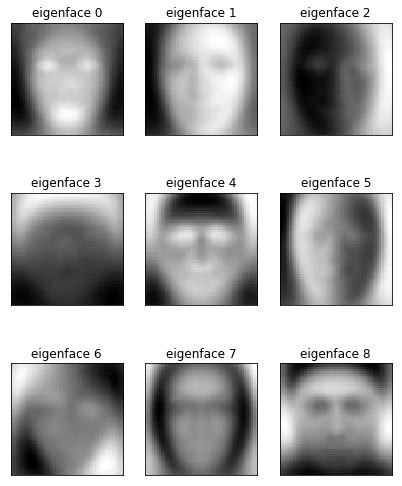

In [15]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 48, 48)
plt.show()

In [16]:
y_train_ = np.argmax(Y_train, axis=-1)
y_train_.shape

(28709,)

In [17]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3],
              'gamma': [0.001], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca[:5000], y_train_[:5000])
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 47.249s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [18]:
print("Predicting people's emotions on the test set")
t0 = time()
y_pred_public= clf.predict(X_val_pca_public)
y_pred_private= clf.predict(X_val_pca_private)
print("done in %0.3fs" % (time() - t0))
y_val_public = np.argmax(Y_test_public, axis=-1)
y_val_private = np.argmax(Y_test_private, axis=-1)
print(classification_report(y_val_public, y_pred_public))
print(confusion_matrix(y_val_public, y_pred_public, labels=range(num_classes)))

Predicting people's emotions on the test set
done in 3.214s
              precision    recall  f1-score   support

           0       0.21      0.31      0.25       467
           1       0.21      0.14      0.17        56
           2       0.21      0.21      0.21       496
           3       0.52      0.54      0.53       895
           4       0.30      0.25      0.27       653
           5       0.52      0.42      0.47       415
           6       0.33      0.30      0.32       607

   micro avg       0.35      0.35      0.35      3589
   macro avg       0.33      0.31      0.32      3589
weighted avg       0.36      0.35      0.35      3589

[[143   3  74  94  76  19  58]
 [ 15   8  10  10   7   1   5]
 [ 96   6 105  90  85  47  67]
 [128   9  71 479  87  28  93]
 [135   8  98 119 164  30  99]
 [ 40   1  75  37  42 176  44]
 [121   3  73  94  92  40 184]]


In [19]:
print(classification_report(y_val_private, y_pred_private))
print(confusion_matrix(y_val_private, y_pred_private, labels=range(num_classes)))

              precision    recall  f1-score   support

           0       0.24      0.32      0.27       491
           1       0.23      0.15      0.18        55
           2       0.26      0.27      0.27       528
           3       0.53      0.53      0.53       879
           4       0.27      0.26      0.26       594
           5       0.46      0.39      0.42       416
           6       0.37      0.35      0.36       626

   micro avg       0.36      0.36      0.36      3589
   macro avg       0.34      0.32      0.33      3589
weighted avg       0.37      0.36      0.37      3589

[[155   6  71  73  88  26  72]
 [  8   8   8  13  10   2   6]
 [ 81   5 143  70  93  65  71]
 [112   8  76 466  89  32  96]
 [132   3  88 103 153  30  85]
 [ 43   2  87  45  39 161  39]
 [112   3  67 102  93  31 218]]
